In [1]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV


In [19]:
df=pd.read_csv("trainingset.txt")
df.head()
df['duration'].unique()
df=df.drop(['duration'],axis=1)

In [20]:
#df.head

In [21]:
queries=pd.read_csv("queries.txt")
queries= queries.drop(['y'], axis=1)
queries= queries.drop(['duration'], axis=1)
queries.head

<bound method NDFrame.head of        age       job   marital  education default  balance housing loan  \
0       58   JobCat6   married   tertiary      no     2143     yes   no   
1       31   JobCat4   married  secondary      no        2     yes  yes   
2       33   JobCat6   married   tertiary      no      231     yes   no   
3       43   JobCat9    single  secondary      no      593     yes   no   
4       27  JobCat11    single  secondary      no      390     yes   no   
...    ...       ...       ...        ...     ...      ...     ...  ...   
17934   23   JobCat5    single  secondary      no      358      no   no   
17935   34   JobCat6    single  secondary      no     1511     yes   no   
17936   53   JobCat6   married   tertiary      no      583      no   no   
17937   51   JobCat9   married   tertiary      no      825      no   no   
17938   71   JobCat2  divorced    primary      no     1729      no   no   

        contact  day month   campaign  pdays  previous poutcome  
0  

In [22]:
'''Data Exploration'''

'Data Exploration'

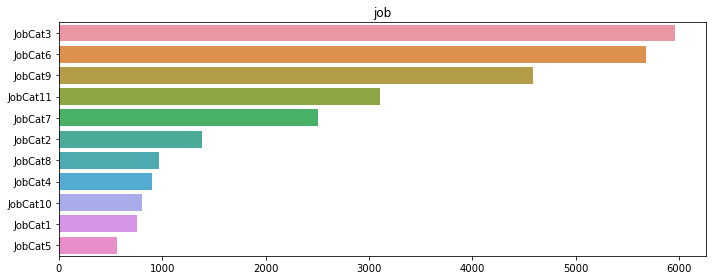

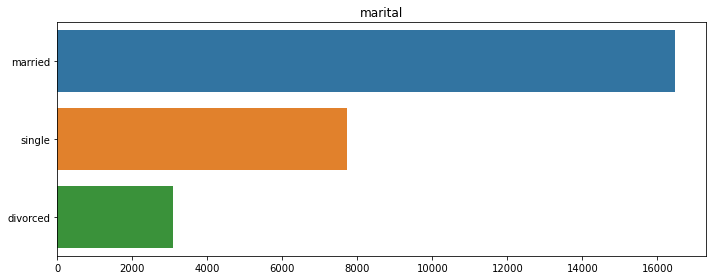

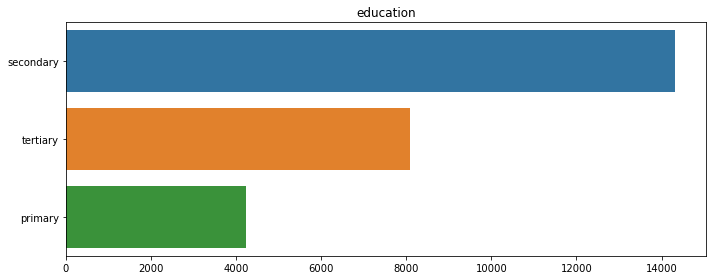

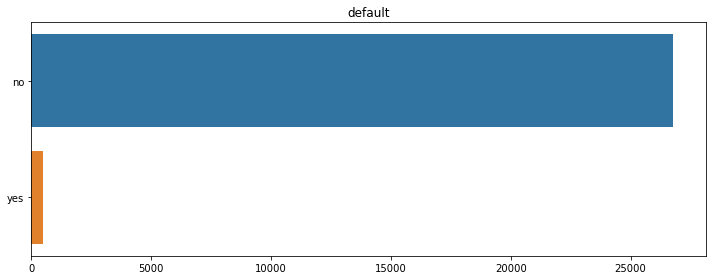

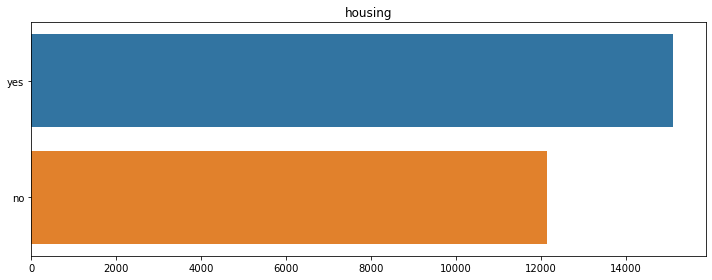

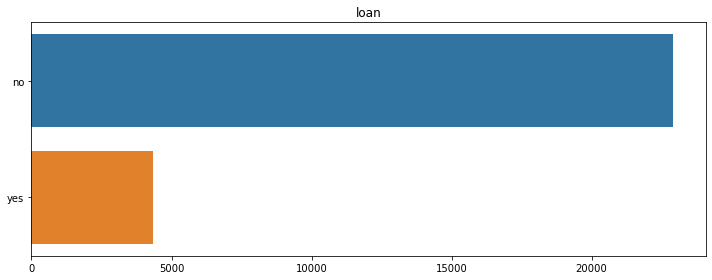

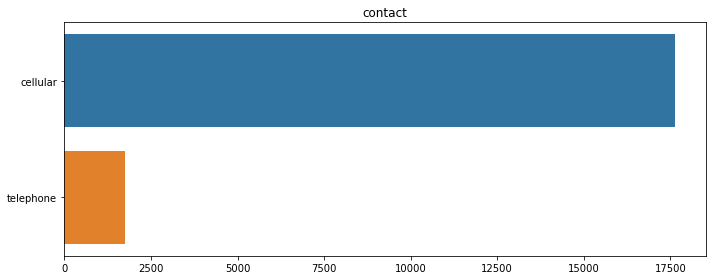

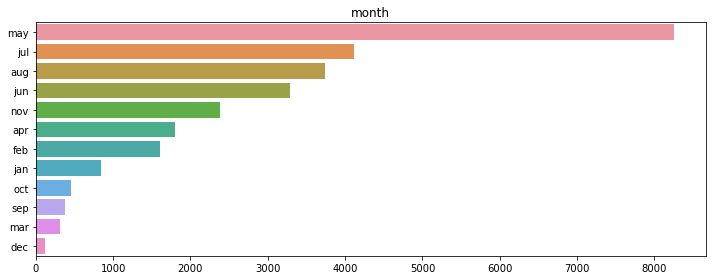

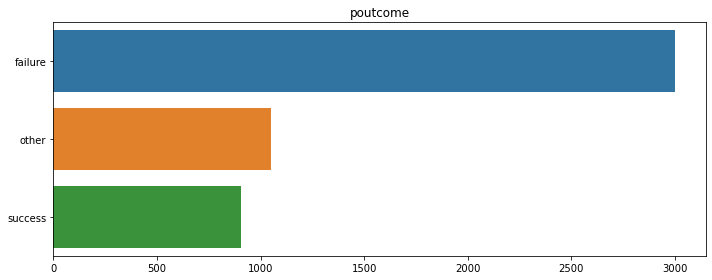

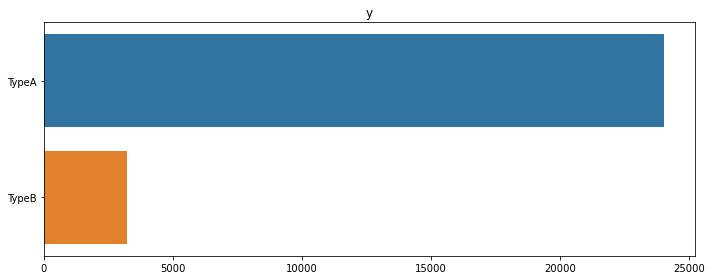

In [64]:
'''Exploring categorical features by number of values for each category'''
categorical = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'poutcome','y']
for col in categorical:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

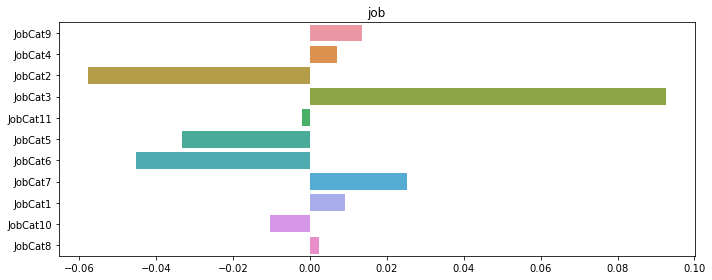

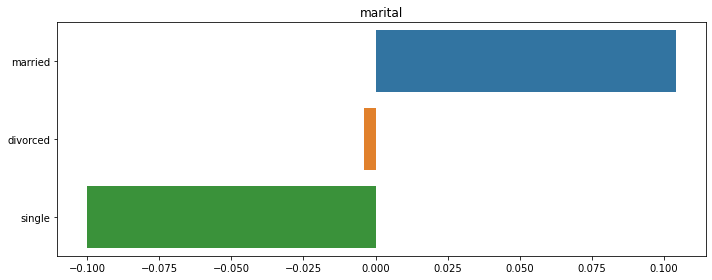

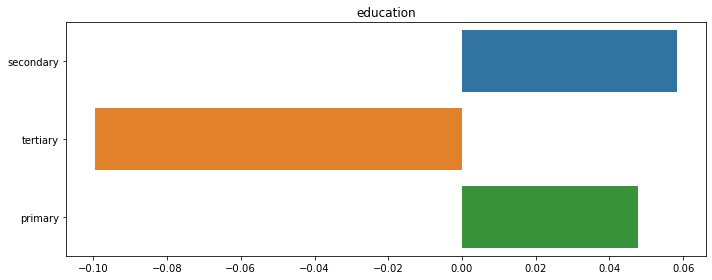

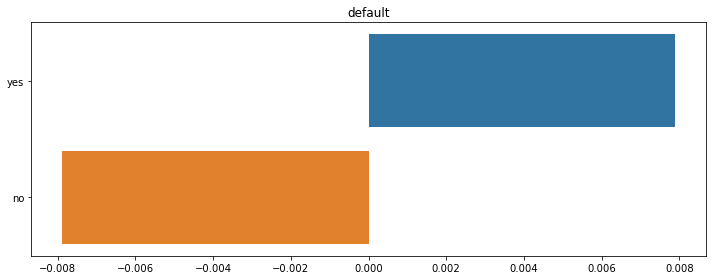

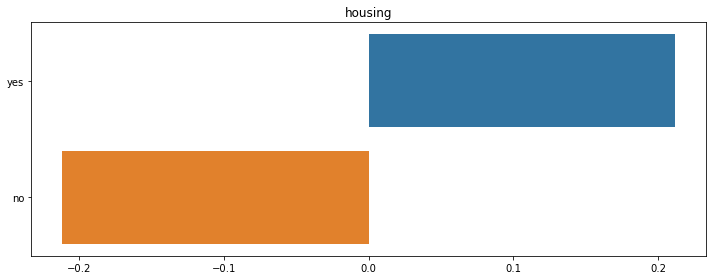

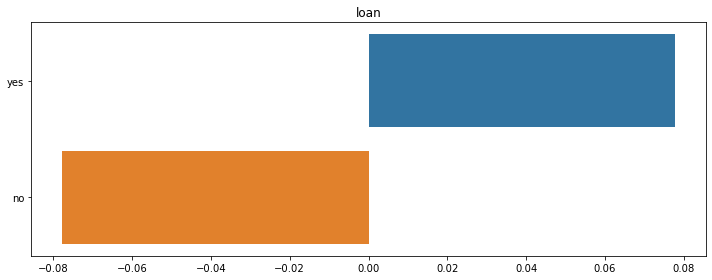

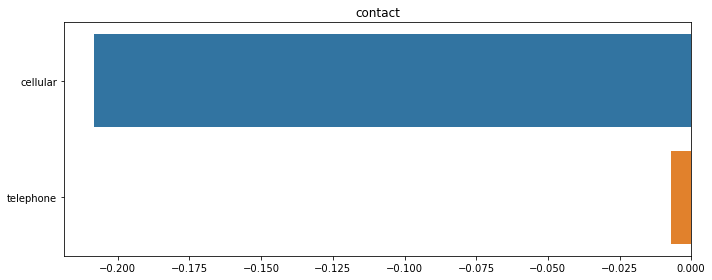

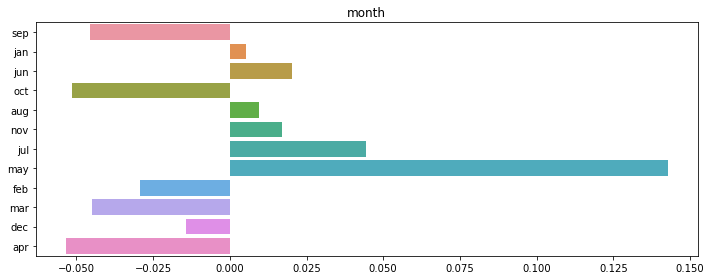

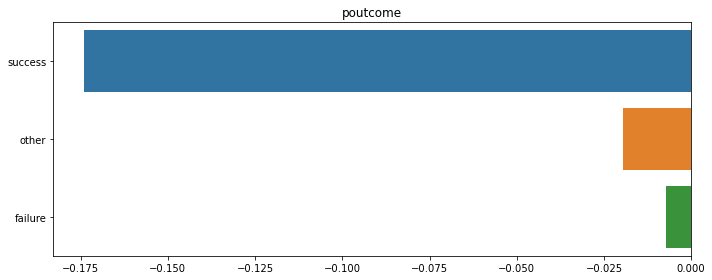

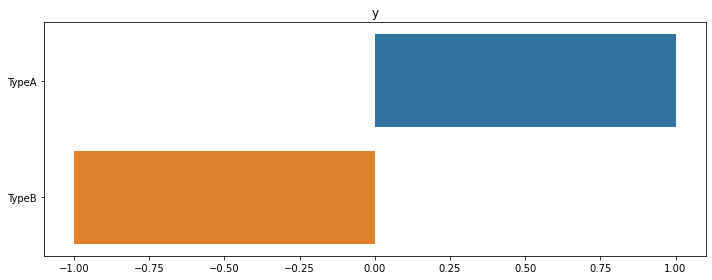

In [65]:
'''Normalized distribution of each class per feature and plotted difference between positive and negative frequencies. 
Positive values imply this category favors clients that will subscribe and negative values categories that favor not 
buying the product.'''
categorcial_variables = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'TypeA', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'TypeB', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'TypeA').sum()
    freq_neg = (df.y.values == 'TypeB').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

In [25]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [66]:
cross_tab(df,'job','education')

,secondary,NaN,tertiary,primary
JobCat1,228,0.0,100,426
JobCat10,443,0.0,175,161
JobCat11,2639,0.0,344,119
JobCat2,590,0.0,224,481
JobCat3,3275,0.0,87,2327
JobCat4,324,0.0,415,113
JobCat5,294,0.0,132,24
JobCat6,666,0.0,4833,185
JobCat7,2190,0.0,106,214
JobCat8,371,0.0,490,81


In [27]:
'''Displaying values for age by job category we could assume that if age is grater than 60 unknow values could be
grouped in Jobcat2'''
df['job'][df['age']>60].value_counts()

JobCat2     522
JobCat6      60
JobCat1      41
JobCat11     19
unknown      17
JobCat9      15
JobCat8      14
JobCat3      14
JobCat4       8
JobCat10      6
Name: job, dtype: int64

In [28]:
def job_cross_edu(df):
    df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'JobCat2'
    '''dealing with unknown values from job and education features: 
     by looking at the education feature if we impute unknown values with most frequent value
     from that row we can get significat amount of unknown values out of the way and infer which education they had,
     same goes vice versa for job'''
    df.loc[(df['education']=='unknown') & (df['job']=='JobCat6'), 'education'] = 'tertiary'
    df.loc[(df['education']=='unknown') & (df['job']=='JobCat9'), 'education'] = 'secondary'
    df.loc[(df['education']=='unknown') & (df['job']=='JobCat11'), 'education'] = 'secondary'
    df.loc[(df['education']=='unknown') & (df['job']=='JobCat7'), 'education'] = 'secondary'
    df.loc[(df['education']=='unknown') & (df['job']=='JobCat1'), 'education'] = 'primary'

    df.loc[(df['job'] == 'unknown') & (df['education']=='primary'), 'job'] = 'JobCat3'
    df.loc[(df['job'] == 'unknown') & (df['education']=='secondary'), 'job'] = 'JobCat9'
    df.loc[(df['job'] == 'unknown') & (df['education']=='tertiary'), 'job'] = 'JobCat6'
    return df
queries = job_cross_edu(queries) #queries file normalization 
job_cross_edu(df)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,44,JobCat9,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,TypeA
1,47,JobCat3,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,TypeA
2,31,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,TypeA
3,26,JobCat6,single,tertiary,no,447,yes,yes,unknown,5,may,1,-1,0,unknown,TypeA
4,42,JobCat4,divorced,tertiary,yes,2,yes,no,unknown,5,may,1,-1,0,unknown,TypeA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27267,73,JobCat2,married,secondary,no,2850,no,no,cellular,17,nov,1,40,8,failure,TypeB
27268,23,JobCat9,single,secondary,no,505,no,yes,cellular,17,nov,2,-1,0,unknown,TypeB
27269,72,JobCat2,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,TypeB
27270,57,JobCat3,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,TypeA


In [29]:
df.job.value_counts()

JobCat3     5958
JobCat6     5684
JobCat9     4583
JobCat11    3102
JobCat7     2510
JobCat2     1387
JobCat8      965
JobCat4      900
JobCat10     800
JobCat1      754
JobCat5      563
unknown       66
Name: job, dtype: int64

In [30]:
df.education.value_counts()

secondary    14319
tertiary      8090
primary       4231
unknown        632
Name: education, dtype: int64

In [31]:
df.poutcome.value_counts()

unknown    22316
failure     2998
other       1052
success      906
Name: poutcome, dtype: int64

In [32]:
df.contact.value_counts()

cellular     17633
unknown       7897
telephone     1742
Name: contact, dtype: int64

In [33]:
'''Replacing rest of unknown values with NaN for easier computation'''
def replaceNaN(df):
    for x in df:
        df['contact'].replace('unknown', np.NaN, inplace=True)
        df['job'].replace('unknown', np.NaN, inplace=True)
        df['education'].replace('unknown', np.NaN, inplace=True)
        df['poutcome'].replace('unknown', np.NaN, inplace=True)
    return df
queries = replaceNaN(queries)#replaced value unknown with NaN
replaceNaN(df)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,44,JobCat9,single,secondary,no,29,yes,no,NaN,5,may,1,-1,0,NaN,TypeA
1,47,JobCat3,married,NaN,no,1506,yes,no,NaN,5,may,1,-1,0,NaN,TypeA
2,31,NaN,single,NaN,no,1,no,no,NaN,5,may,1,-1,0,NaN,TypeA
3,26,JobCat6,single,tertiary,no,447,yes,yes,NaN,5,may,1,-1,0,NaN,TypeA
4,42,JobCat4,divorced,tertiary,yes,2,yes,no,NaN,5,may,1,-1,0,NaN,TypeA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27267,73,JobCat2,married,secondary,no,2850,no,no,cellular,17,nov,1,40,8,failure,TypeB
27268,23,JobCat9,single,secondary,no,505,no,yes,cellular,17,nov,2,-1,0,NaN,TypeB
27269,72,JobCat2,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,TypeB
27270,57,JobCat3,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,NaN,TypeA


In [67]:
'''check for missing values in categorical features'''
df[categorical].isnull().sum()

job             66
marital          0
education      632
default          0
housing          0
loan             0
contact       7897
month            0
poutcome     22316
y                0
dtype: int64

In [68]:

'''displaying number of labels in categorical features with which we will have to deal later'''
for var in categorcial_variables:
    
    print(var, ' contains ', len(df[var].unique()), ' labels')

job  contains  12  labels
marital  contains  3  labels
education  contains  4  labels
default  contains  2  labels
housing  contains  2  labels
loan  contains  2  labels
contact  contains  3  labels
month  contains  12  labels
poutcome  contains  4  labels
y  contains  2  labels


In [ ]:
'''Checking NUMERICAL features'''

In [ ]:
numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :', numerical)

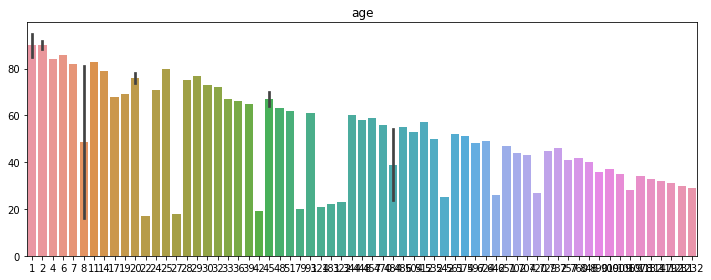

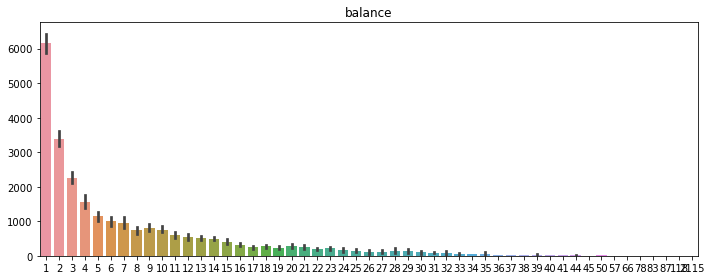

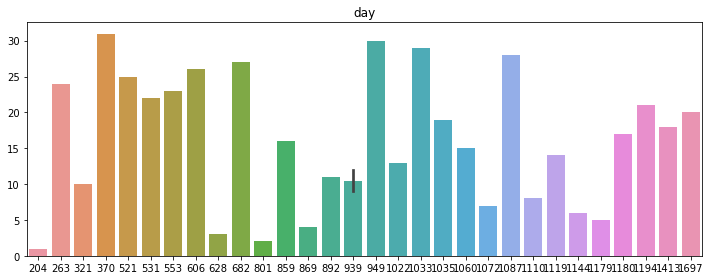

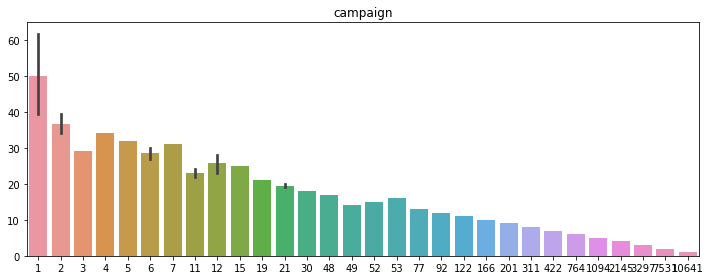

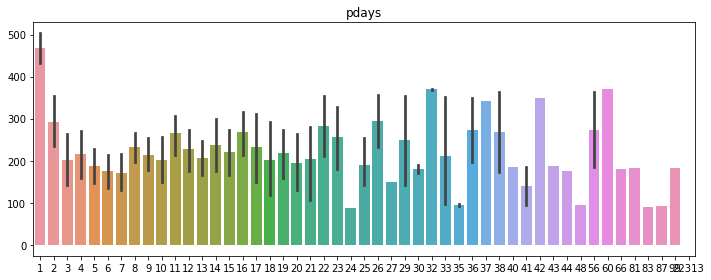

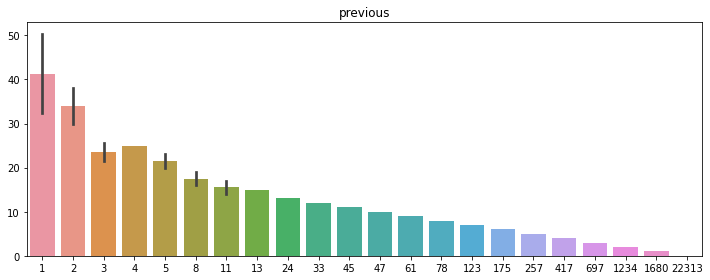

In [69]:
'''Exploring numerical features by number of values for each category'''
for col in numerical:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()

In [71]:
#check for missing values
df[numerical].isnull().sum()

age         0
balance     0
day         0
campaign    0
pdays       0
previous    0
dtype: int64

In [72]:
'''Declare feature vector and target variable'''
X = df.drop(['y'], axis=1)

Y = df['y']
X.dtypes


age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [76]:
''' split X and y into training and testing sets'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [77]:
X_train.shape, X_test.shape

((19090, 15), (8182, 15))

In [78]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [79]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

In [80]:
X_train[categorical].isnull().mean()

job          0.002252
marital      0.000000
education    0.023258
default      0.000000
housing      0.000000
loan         0.000000
contact      0.290047
month        0.000000
poutcome     0.817968
dtype: float64

In [81]:
''' fill rest of NaN'''
def fillNaN(df):
    df['job'].fillna(df['job'].mode()[0], inplace=True)
    df['education'].fillna(df['education'].mode()[0], inplace=True)
    df['poutcome'].fillna(df['poutcome'].mode()[0], inplace=True)
    df['contact'].fillna(df['contact'].mode()[0], inplace=True)

fillNaN(queries)
fillNaN(X_train)
fillNaN(X_test)

In [82]:
#queries.head
X_train[categorical].isnull().mean()

job          0.0
marital      0.0
education    0.0
default      0.0
housing      0.0
loan         0.0
contact      0.0
month        0.0
poutcome     0.0
dtype: float64

In [83]:
'''check for missing values'''
X_train[categorical].isnull().sum()

job          0
marital      0
education    0
default      0
housing      0
loan         0
contact      0
month        0
poutcome     0
dtype: int64

In [84]:
print(X_train.shape,X_test.shape)

(19090, 15) (8182, 15)


In [85]:
import category_encoders as ce
# encode remaining variables with one-hot encoding
'''each label of categorical feature is transformed in 1 or 0 if true or false and for each label column is created 
, we can see from 15 columns number of columns whent up to 47'''
encoder = ce.OneHotEncoder(cols = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'poutcome']
)
X_queries = encoder.fit_transform(queries)
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

In [86]:
#X_queries.shape


In [87]:
'''Standardizing '''
cols = X_train.columns
cols_queries = X_queries.columns
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_queries = scaler.fit_transform(X_queries)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

X_queries = pd.DataFrame(X_queries, columns=[cols_queries])

X_train = pd.DataFrame(X_train, columns=[cols])

X_test = pd.DataFrame(X_test, columns=[cols])



In [88]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

GaussianNB()

In [146]:
'''compute solutions file'''
y_pred_queries = gnb.predict(X_queries)
with open('D17125507.txt', 'w') as cod:
    x = 1
    for i in range(len(y_pred_queries)):
        cod.write('{},{}'.format(x,y_pred_queries[i]))
        cod.write(",\n")
        x+=1
    cod.close()
    
with open('D17125507.txt', 'r') as codread:
    c = codread.readlines()
    print(c)
    codread.close()



['1,TypeA,\n', '2,TypeA,\n', '3,TypeA,\n', '4,TypeA,\n', '5,TypeA,\n', '6,TypeA,\n', '7,TypeA,\n', '8,TypeA,\n', '9,TypeA,\n', '10,TypeA,\n', '11,TypeA,\n', '12,TypeA,\n', '13,TypeA,\n', '14,TypeA,\n', '15,TypeA,\n', '16,TypeA,\n', '17,TypeA,\n', '18,TypeA,\n', '19,TypeA,\n', '20,TypeA,\n', '21,TypeA,\n', '22,TypeA,\n', '23,TypeA,\n', '24,TypeA,\n', '25,TypeA,\n', '26,TypeA,\n', '27,TypeA,\n', '28,TypeA,\n', '29,TypeA,\n', '30,TypeA,\n', '31,TypeA,\n', '32,TypeA,\n', '33,TypeA,\n', '34,TypeA,\n', '35,TypeA,\n', '36,TypeA,\n', '37,TypeA,\n', '38,TypeA,\n', '39,TypeA,\n', '40,TypeA,\n', '41,TypeA,\n', '42,TypeA,\n', '43,TypeA,\n', '44,TypeA,\n', '45,TypeA,\n', '46,TypeA,\n', '47,TypeA,\n', '48,TypeA,\n', '49,TypeA,\n', '50,TypeA,\n', '51,TypeA,\n', '52,TypeA,\n', '53,TypeA,\n', '54,TypeA,\n', '55,TypeA,\n', '56,TypeA,\n', '57,TypeA,\n', '58,TypeA,\n', '59,TypeA,\n', '60,TypeA,\n', '61,TypeA,\n', '62,TypeA,\n', '63,TypeA,\n', '64,TypeA,\n', '65,TypeA,\n', '66,TypeA,\n', '67,TypeA,\n', '68

In [90]:
'''check the model for prediction on test data'''
y_pred_test = gnb.predict(X_test)

y_pred_test
for x in enumerate(y_pred_test):
    print(x)
y_pred_test.shape

(0, 'TypeA')
(1, 'TypeB')
(2, 'TypeB')
(3, 'TypeB')
(4, 'TypeA')
(5, 'TypeA')
(6, 'TypeB')
(7, 'TypeA')
(8, 'TypeA')
(9, 'TypeB')
(10, 'TypeA')
(11, 'TypeB')
(12, 'TypeA')
(13, 'TypeA')
(14, 'TypeA')
(15, 'TypeA')
(16, 'TypeA')
(17, 'TypeA')
(18, 'TypeA')
(19, 'TypeA')
(20, 'TypeA')
(21, 'TypeA')
(22, 'TypeA')
(23, 'TypeA')
(24, 'TypeA')
(25, 'TypeB')
(26, 'TypeA')
(27, 'TypeA')
(28, 'TypeA')
(29, 'TypeA')
(30, 'TypeA')
(31, 'TypeA')
(32, 'TypeA')
(33, 'TypeA')
(34, 'TypeA')
(35, 'TypeA')
(36, 'TypeA')
(37, 'TypeA')
(38, 'TypeB')
(39, 'TypeA')
(40, 'TypeA')
(41, 'TypeA')
(42, 'TypeA')
(43, 'TypeA')
(44, 'TypeA')
(45, 'TypeA')
(46, 'TypeB')
(47, 'TypeA')
(48, 'TypeA')
(49, 'TypeA')
(50, 'TypeA')
(51, 'TypeA')
(52, 'TypeA')
(53, 'TypeA')
(54, 'TypeA')
(55, 'TypeA')
(56, 'TypeB')
(57, 'TypeA')
(58, 'TypeA')
(59, 'TypeA')
(60, 'TypeA')
(61, 'TypeB')
(62, 'TypeB')
(63, 'TypeA')
(64, 'TypeA')
(65, 'TypeA')
(66, 'TypeA')
(67, 'TypeB')
(68, 'TypeA')
(69, 'TypeA')
(70, 'TypeA')
(71, 'TypeA')
(7

(1544, 'TypeA')
(1545, 'TypeA')
(1546, 'TypeA')
(1547, 'TypeA')
(1548, 'TypeB')
(1549, 'TypeA')
(1550, 'TypeA')
(1551, 'TypeA')
(1552, 'TypeA')
(1553, 'TypeB')
(1554, 'TypeA')
(1555, 'TypeB')
(1556, 'TypeA')
(1557, 'TypeA')
(1558, 'TypeA')
(1559, 'TypeB')
(1560, 'TypeB')
(1561, 'TypeA')
(1562, 'TypeA')
(1563, 'TypeA')
(1564, 'TypeA')
(1565, 'TypeB')
(1566, 'TypeA')
(1567, 'TypeA')
(1568, 'TypeA')
(1569, 'TypeA')
(1570, 'TypeA')
(1571, 'TypeA')
(1572, 'TypeA')
(1573, 'TypeA')
(1574, 'TypeA')
(1575, 'TypeB')
(1576, 'TypeA')
(1577, 'TypeA')
(1578, 'TypeA')
(1579, 'TypeA')
(1580, 'TypeA')
(1581, 'TypeA')
(1582, 'TypeA')
(1583, 'TypeA')
(1584, 'TypeB')
(1585, 'TypeA')
(1586, 'TypeA')
(1587, 'TypeA')
(1588, 'TypeA')
(1589, 'TypeA')
(1590, 'TypeA')
(1591, 'TypeA')
(1592, 'TypeA')
(1593, 'TypeA')
(1594, 'TypeA')
(1595, 'TypeA')
(1596, 'TypeA')
(1597, 'TypeA')
(1598, 'TypeA')
(1599, 'TypeB')
(1600, 'TypeA')
(1601, 'TypeA')
(1602, 'TypeA')
(1603, 'TypeA')
(1604, 'TypeA')
(1605, 'TypeA')
(1606, '

(3320, 'TypeA')
(3321, 'TypeA')
(3322, 'TypeA')
(3323, 'TypeA')
(3324, 'TypeA')
(3325, 'TypeA')
(3326, 'TypeA')
(3327, 'TypeB')
(3328, 'TypeA')
(3329, 'TypeA')
(3330, 'TypeA')
(3331, 'TypeA')
(3332, 'TypeB')
(3333, 'TypeB')
(3334, 'TypeA')
(3335, 'TypeA')
(3336, 'TypeA')
(3337, 'TypeA')
(3338, 'TypeA')
(3339, 'TypeA')
(3340, 'TypeA')
(3341, 'TypeA')
(3342, 'TypeA')
(3343, 'TypeA')
(3344, 'TypeA')
(3345, 'TypeA')
(3346, 'TypeA')
(3347, 'TypeA')
(3348, 'TypeA')
(3349, 'TypeA')
(3350, 'TypeB')
(3351, 'TypeA')
(3352, 'TypeA')
(3353, 'TypeA')
(3354, 'TypeA')
(3355, 'TypeA')
(3356, 'TypeA')
(3357, 'TypeA')
(3358, 'TypeA')
(3359, 'TypeA')
(3360, 'TypeA')
(3361, 'TypeA')
(3362, 'TypeA')
(3363, 'TypeB')
(3364, 'TypeA')
(3365, 'TypeA')
(3366, 'TypeA')
(3367, 'TypeA')
(3368, 'TypeA')
(3369, 'TypeA')
(3370, 'TypeA')
(3371, 'TypeA')
(3372, 'TypeA')
(3373, 'TypeA')
(3374, 'TypeA')
(3375, 'TypeA')
(3376, 'TypeA')
(3377, 'TypeA')
(3378, 'TypeA')
(3379, 'TypeA')
(3380, 'TypeB')
(3381, 'TypeA')
(3382, '

(5269, 'TypeA')
(5270, 'TypeA')
(5271, 'TypeA')
(5272, 'TypeA')
(5273, 'TypeA')
(5274, 'TypeA')
(5275, 'TypeA')
(5276, 'TypeA')
(5277, 'TypeA')
(5278, 'TypeA')
(5279, 'TypeA')
(5280, 'TypeA')
(5281, 'TypeA')
(5282, 'TypeA')
(5283, 'TypeA')
(5284, 'TypeA')
(5285, 'TypeA')
(5286, 'TypeA')
(5287, 'TypeA')
(5288, 'TypeA')
(5289, 'TypeA')
(5290, 'TypeA')
(5291, 'TypeA')
(5292, 'TypeA')
(5293, 'TypeA')
(5294, 'TypeA')
(5295, 'TypeA')
(5296, 'TypeA')
(5297, 'TypeA')
(5298, 'TypeA')
(5299, 'TypeB')
(5300, 'TypeA')
(5301, 'TypeA')
(5302, 'TypeA')
(5303, 'TypeA')
(5304, 'TypeA')
(5305, 'TypeA')
(5306, 'TypeA')
(5307, 'TypeA')
(5308, 'TypeA')
(5309, 'TypeA')
(5310, 'TypeA')
(5311, 'TypeB')
(5312, 'TypeA')
(5313, 'TypeB')
(5314, 'TypeA')
(5315, 'TypeA')
(5316, 'TypeB')
(5317, 'TypeA')
(5318, 'TypeA')
(5319, 'TypeA')
(5320, 'TypeA')
(5321, 'TypeA')
(5322, 'TypeA')
(5323, 'TypeA')
(5324, 'TypeA')
(5325, 'TypeA')
(5326, 'TypeA')
(5327, 'TypeA')
(5328, 'TypeA')
(5329, 'TypeA')
(5330, 'TypeA')
(5331, '

(7110, 'TypeA')
(7111, 'TypeA')
(7112, 'TypeA')
(7113, 'TypeA')
(7114, 'TypeA')
(7115, 'TypeA')
(7116, 'TypeB')
(7117, 'TypeA')
(7118, 'TypeA')
(7119, 'TypeA')
(7120, 'TypeA')
(7121, 'TypeA')
(7122, 'TypeA')
(7123, 'TypeA')
(7124, 'TypeA')
(7125, 'TypeA')
(7126, 'TypeA')
(7127, 'TypeA')
(7128, 'TypeB')
(7129, 'TypeB')
(7130, 'TypeA')
(7131, 'TypeA')
(7132, 'TypeA')
(7133, 'TypeA')
(7134, 'TypeA')
(7135, 'TypeA')
(7136, 'TypeA')
(7137, 'TypeA')
(7138, 'TypeA')
(7139, 'TypeA')
(7140, 'TypeA')
(7141, 'TypeB')
(7142, 'TypeB')
(7143, 'TypeA')
(7144, 'TypeA')
(7145, 'TypeA')
(7146, 'TypeA')
(7147, 'TypeA')
(7148, 'TypeB')
(7149, 'TypeA')
(7150, 'TypeA')
(7151, 'TypeA')
(7152, 'TypeA')
(7153, 'TypeA')
(7154, 'TypeA')
(7155, 'TypeA')
(7156, 'TypeA')
(7157, 'TypeA')
(7158, 'TypeA')
(7159, 'TypeA')
(7160, 'TypeB')
(7161, 'TypeA')
(7162, 'TypeA')
(7163, 'TypeA')
(7164, 'TypeA')
(7165, 'TypeA')
(7166, 'TypeA')
(7167, 'TypeA')
(7168, 'TypeA')
(7169, 'TypeA')
(7170, 'TypeA')
(7171, 'TypeA')
(7172, '

(8182,)

In [91]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.8427


In [ ]:
'''check the model for prediction on train data'''

y_pred_train = gnb.predict(X_train)

y_pred_train

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

In [ ]:
'''check for number of types for each category in target feature'''
y_test.value_counts()

In [ ]:
sns.displot(y_pred_test)

In [ ]:
'''check for confusion matrix test for test data'''
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlOrRd')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

In [ ]:
'''Recall can be defined as the percentage of correctly predicted positive outcomes out of all
the actual positive outcomes. It can be given as the ratio of true positives (TP) to the sum 
of true positives and false negatives (TP + FN)'''

'''Support is the actual number of occurrences of the class in our dataset.'''

'''f1-score is the weighted harmonic mean of precision and recall. The best possible f1-score 
would be 1.0 and the worst would be 0.0. f1-score is the harmonic mean of precision and recall. 
So, f1-score is always lower than accuracy measures as they embed precision and recall into their 
computation. The weighted average of f1-score should be used to compare classifier models, not global accuracy.'''

'''Precision can be defined as the percentage of correctly predicted positive outcomes out of all the predicted 
positive outcomes. 
It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP).
So, Precision identifies the proportion of correctly predicted positive outcome. 
It is more concerned with the positive class than the negative class.'''

In [ ]:
# print classification accuracy

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

In [ ]:
# print classification error
'''check how much is our model of and does it add up to one'''
classification_error = (FP + FN) / float(TP + TN + FP + FN)


print('Classification error : {0:0.4f}'.format(classification_error))

In [ ]:
y_pred_prob = gnb.predict_proba(X_queries)[0:10]
y_pred_prob

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
#Runs sklearn's decision tree algorithm on the training data with min leaf size 1 and split size 2
dt=DecisionTreeClassifier(criterion='entropy',min_samples_leaf=1,min_samples_split=2) 
dt.fit(X_train,y_train)   
predict_proba_val=dt.predict(X_test)
predict_proba_val
X_train.head
#imp=dt.feature_importances_


<bound method NDFrame.head of             age job_1 job_2 job_3 job_4 job_5 job_6 job_7 job_8 job_9  ...  \
0     -0.529412   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1     -0.294118   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2      0.411765   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3      0.000000   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4      0.647059   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
19085  0.764706   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19086 -0.470588   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...   
19087 -0.705882   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0  ...   
19088  0.764706   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
19089 -0.411765   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

      month_9 month_10 month_11 m

In [63]:
'''we can see that its performing little bit worse than Naive Bayes'''
accuracy=metrics.accuracy_score(y_test,dt.predict(X_test)) #Compute subset accuracy classification score
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))

Training-set accuracy score: 0.8266


In [55]:
'''from here we can see there is no solution for some prediction while Naive Bayes will generalize over data set,
and in this case make right predictions'''
po = pd.DataFrame(data=[y_train, predict_proba_val],index=['y_train','predict_proba_val'])
po.transpose()

,y_train,predict_proba_val
3870,TypeA,TypeB
7969,TypeA,TypeB
15152,TypeA,TypeA
21882,TypeA,NaN
9692,TypeA,TypeA
...,...,...
13123,TypeA,TypeA
19648,TypeA,NaN
9845,TypeA,TypeA
10799,TypeA,TypeA
